In [1]:
#pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.4 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
from transformers import TFBertForSequenceClassification, AdamW, BertConfig
from sklearn.utils import resample

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# text preprocessing modules
from string import punctuation 
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression
# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package

In [3]:
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  grpc://10.50.15.234:8470


REPLICAS:  8


In [4]:
df=pd.read_csv('/content/drive/MyDrive/train.csv')


In [5]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
def map_to_binary(value):
    if value < 0.5:
        return 0
    else:
        return 1

In [7]:
df['label'] = df['target'].apply(map_to_binary)

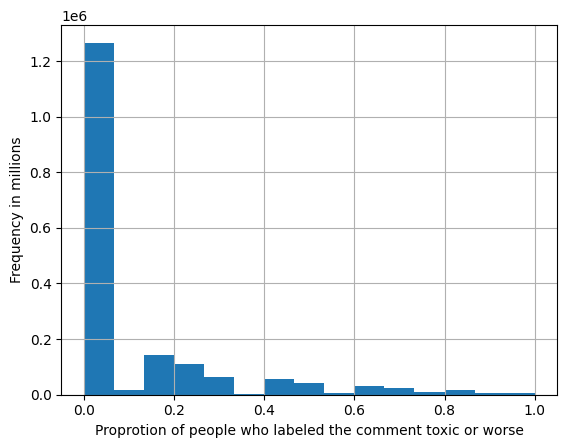

In [ ]:
# This is a histogram of the target column which represents the ratio of people who labeled the specific comment toxic or worse.
df['target'].hist(bins=15)
plt.xlabel('Proprotion of people who labeled the comment toxic or worse')
plt.ylabel('Frequency in millions')
plt.show()

In [8]:
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]
print(len(class_1))
print(len(class_0))

144334
1660540


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3.738434e+06,2.445187e+06,59848.0,796975.25,5223774.5,5.769854e+06,6334010.00
target,1804874.0,1.030173e-01,1.970757e-01,0.0,0.00,0.0,1.666667e-01,1.00
severe_toxicity,1804874.0,4.582099e-03,2.286128e-02,0.0,0.00,0.0,0.000000e+00,1.00
obscene,1804874.0,1.387721e-02,6.460419e-02,0.0,0.00,0.0,0.000000e+00,1.00
identity_attack,1804874.0,2.263571e-02,7.873156e-02,0.0,0.00,0.0,0.000000e+00,1.00
insult,1804874.0,8.115273e-02,1.760657e-01,0.0,0.00,0.0,9.090909e-02,1.00
threat,1804874.0,9.311271e-03,4.942218e-02,0.0,0.00,0.0,0.000000e+00,1.00
asian,405130.0,1.196355e-02,8.716616e-02,0.0,0.00,0.0,0.000000e+00,1.00
atheist,405130.0,3.205019e-03,5.019273e-02,0.0,0.00,0.0,0.000000e+00,1.00
bisexual,405130.0,1.884285e-03,2.607737e-02,0.0,0.00,0.0,0.000000e+00,1.00


In [ ]:
df.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [8]:
new_df = df[['label', 'comment_text']].copy()

In [9]:
new_df.head()

,label,comment_text
0,0,"This is so cool. It's like, 'would you want yo..."
1,0,Thank you!! This would make my life a lot less...
2,0,This is such an urgent design problem; kudos t...
3,0,Is this something I'll be able to install on m...
4,1,haha you guys are a bunch of losers.


In [10]:
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]
print(len(class_1))
print(len(class_0))

144334
1660540


In [11]:
class_counts = new_df['label'].value_counts()

In [12]:
# count the number of positive and negative examples
num_positive = len(new_df[new_df['label'] == 1])
num_negative = len(new_df[new_df['label'] == 0])

# calculate the desired number of positive examples after downsampling
desired_num_positive = int(0.2 * (num_positive + num_negative))

# downsample the negative examples to the desired ratio
df_majority = new_df[new_df['label'] == 0]
df_minority = new_df[new_df['label'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=desired_num_positive-num_positive, random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])



In [13]:
desired_num_positive

360974

In [17]:
(df_downsampled['label']==1).sum()

144334

In [13]:
# Downsample the majority class
class_0_downsampled = resample(class_0,
                               replace=False, # sample without replacement|
                               n_samples=len(class_1), # match minority n
                               random_state=42) # reproducible results

# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([class_0_downsampled, class_1])

# Shuffle the data
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

In [16]:
df_downsampled

,label,comment_text
465260,0,".\n\nThe next time you buy a car, all things b..."
412588,0,I don't trust Nanos Polling.
1268212,0,Police took the woman's version that the 70 y....
589120,0,The study found that between 2-8% of assault c...
714482,0,Seems most of the new jobs are part time so th...
...,...,...
1804825,1,Who is the jerk in the last row between the C ...
1804838,1,Nobody really cares that she supports the scie...
1804856,1,Believing in God or not believing in God are p...
1804857,1,"I take your point, but I think you're shooting..."


In [18]:
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


In [19]:

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase the text
    text = text.lower()
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # tokenize the text
    words = nltk.word_tokenize(text)
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # join words back into sentence
    text = ' '.join(words)
    return text

In [20]:
df_downsampled['clean_text'] = df_downsampled['comment_text'].apply(preprocess_text)

In [21]:
df_downsampled.loc[df.label == 0].sample(10)[['clean_text', 'label']]

,clean_text,label
787721,bravo maestro federer definitely the greatest ...,0
34741,of course climate change is a hoax doesnt ever...,0
20986,doe this mean they are going to fly virgin to ...,0
563752,a reading of the letter to the hebrew describe...,0
388917,the crossover with marginal tax rate is schedu...,0
217338,if philpott want to force a national standard ...,0
1711754,thanks for ceding the point with fallacy,0
1708444,one can only hope that billy morneaus pernicio...,0
340036,cont toronto based city get a poll done not th...,0
668730,maybe if the democrat were more concerned with...,0


In [22]:
df_downsampled.to_csv('/content/drive/MyDrive/cleantrain.csv')

In [23]:
df_downsampled.to_pickle('/content/drive/MyDrive/cleantrain.pkl')  # where to save it, usually as a .pkl

In [4]:
df_downsampled = pd.read_csv('/content/drive/MyDrive/cleantrain.csv')

In [5]:
df_train, df_test = train_test_split(df_downsampled, test_size=0.05, random_state=22)

In [6]:
max_len=340
sentences=df_train['clean_text']
labels=df_train['label']
len(sentences),len(labels)

(342925, 342925)

In [7]:
num_classes = 2

In [8]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Loading BERT tokenizer...


In [9]:
pickle_inp_path='/content/drive/MyDrive/dbertA_inp.pkl'
pickle_mask_path='/content/drive/MyDrive/dbertA_mask.pkl'
pickle_label_path='/content/drive/MyDrive/dbertA_label.pkl'

In [29]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
pickle.dump(input_ids, open(pickle_inp_path, 'wb'))
pickle.dump(attention_masks, open(pickle_mask_path, 'wb'))
pickle.dump(labels, open(pickle_label_path, 'wb'))

In [10]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (342925, 340) Attention mask shape (342925, 340) Input label shape (342925,)


In [16]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='/content/drive/MyDrive/bertmodel.h5'

Train inp shape (274340, 340) Val input shape (68585, 340)
Train label shape (274340,) Val label shape (68585,)
Train attention mask shape (274340, 340) Val attention mask shape (68585, 340)


In [11]:
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [17]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(1))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

    
    return model

In [18]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
with strategy.scope(): 
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  metric = tf.keras.metrics.BinaryAccuracy("binary_accuracy")
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)
  dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
  model = create_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 340)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 340)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_3[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_4[0][0]']                
                                one, 340, 768),                                                   
                                 hidden_states=None                                         

In [20]:
STEPS_PER_EPOCH = len(train_inp) // 64

In [21]:
history=model.fit([train_inp,train_mask],train_label,batch_size=64,epochs=4,steps_per_epoch=STEPS_PER_EPOCH,validation_data=([val_inp,val_mask],val_label), callbacks=[callback])

Epoch 1/4
4286/4286 [==============================] - 541s 113ms/step - loss: 42.1595 - binary_accuracy: 0.8846 - val_loss: 0.5145 - val_binary_accuracy: 0.8895 - lr: 5.0000e-05
Epoch 2/4
4286/4286 [==============================] - 504s 110ms/step - loss: 0.4603 - binary_accuracy: 0.9101 - val_loss: 0.4543 - val_binary_accuracy: 0.8934 - lr: 4.5242e-05
Epoch 3/4
4286/4286 [==============================] - 471s 110ms/step - loss: 0.3846 - binary_accuracy: 0.9320 - val_loss: 0.4255 - val_binary_accuracy: 0.8938 - lr: 4.0937e-05
Epoch 4/4
4286/4286 [==============================] - 470s 110ms/step - loss: 0.3265 - binary_accuracy: 0.9499 - val_loss: 0.4229 - val_binary_accuracy: 0.8917 - lr: 3.7041e-05


In [22]:
preds = model.predict([val_inp,val_mask],batch_size=32)
pred_labels = preds.argmax(axis=1)

2144/2144 [==============================] - 53s 23ms/step


In [46]:
pred_labels = np.where(preds > 0.5, 1, 0)

In [47]:
pred_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [48]:
pred_labels = pred_labels.flatten()

In [49]:
pred_labels

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
Pkl_Filename = "tfbert_jig.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


<ipython-input-23-7e43108e1c00>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


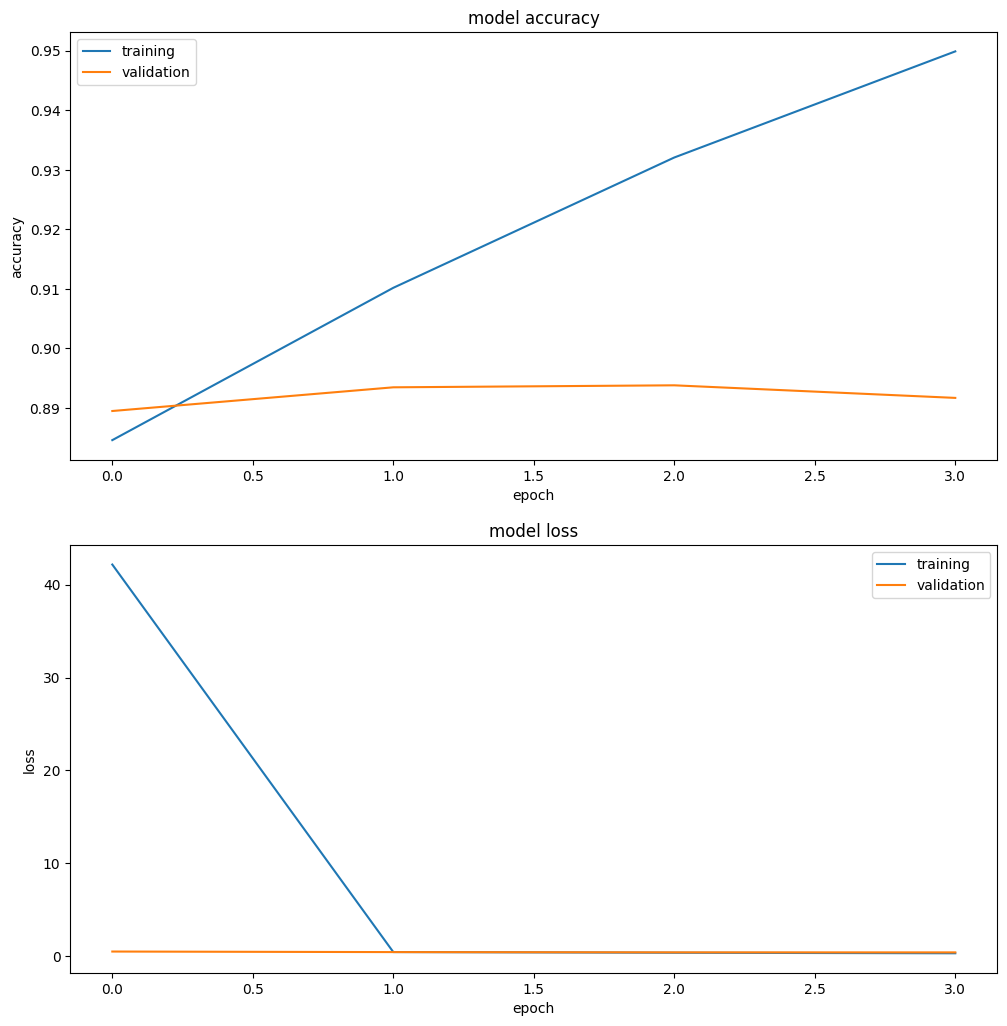

In [23]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['binary_accuracy'], history.history['val_binary_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

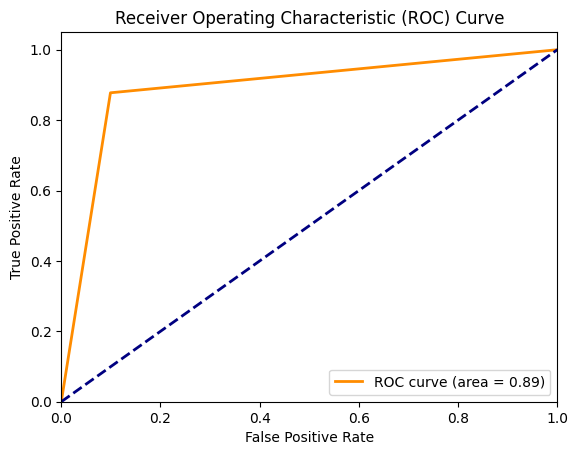

In [50]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
fpr, tpr, thresholds = roc_curve(val_label, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [51]:
print(classification_report(val_label, pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     41320
           1       0.85      0.88      0.87     27265

    accuracy                           0.89     68585
   macro avg       0.89      0.89      0.89     68585
weighted avg       0.89      0.89      0.89     68585

